Our data source was taken from University of Applied Sciences, Ostwestfalen-Lippe, so we're going to assume the banknotes in question are from Germany.

According to https://www.ecb.europa.eu/stats/policy_and_exchange_rates/banknotes+coins/circulation/html/index.en.html,
there are 29 billion Euro bills in cirulation as of Oct 2022. According to the Baltic Times, 347,000 Euro bills were withdrawn from circulation in 2021. While this may only be 0.0012% of the total in circulation, it is still a large enough amount to hurt small businesses and independent workers.

My hypothesis is that there is a relation between our 4 features and whether the banknote is fake or real.
The null hypthesis states that there is in fact no relationship between the 4 features and whether the banknotes are real or fake.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection  import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine

from sklearn.preprocessing import normalize

from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn import neighbors
from sklearn import ensemble

from sklearn import tree
from IPython.display import Image
import itertools


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix, precision_score, recall_score

import pydotplus
import graphviz

In [ ]:
#dataset is for determining if a banknote is authentic or not

# download dataset at https://www.kaggle.com/code/nataliakhol/banknote-classification-with-svm-from-scratch/data
banknotes = pd.read_csv('BankNoteAuthentication.csv')

In [ ]:
#lets start with data cleaning, we're dealing with continuous interval variables
banknotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [ ]:
banknotes.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
#all columns are numerical, lets see if there's any missing numbers
for col in banknotes.columns:
    print('Missing values for {}: {}'.format(col, banknotes[col].isna().sum()))

Missing values for variance: 0
Missing values for skewness: 0
Missing values for curtosis: 0
Missing values for entropy: 0
Missing values for class: 0


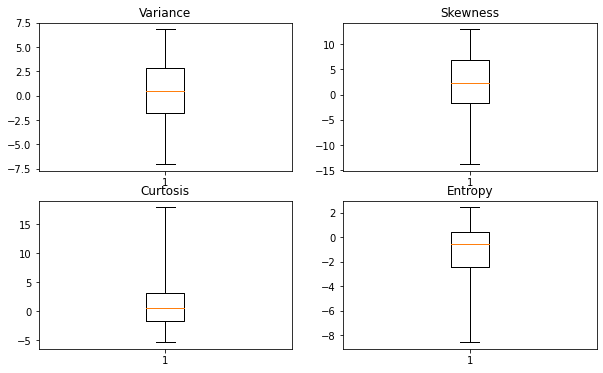

In [ ]:
#we have no missing values, and all the values are floats/int
#lets see if there are any outliers

plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.boxplot(banknotes["variance"])
plt.title("Variance")

plt.subplot(2,2,2)
plt.boxplot(banknotes["skewness"])
plt.title("Skewness")

plt.subplot(2,2,3)
plt.boxplot(banknotes["curtosis"], whis = 5)
plt.title("Curtosis")

plt.subplot(2,2,4)
plt.boxplot(banknotes["entropy"], whis = 5)
plt.title("Entropy")

plt.show()

Text(0.5, 1.0, 'Entropy')

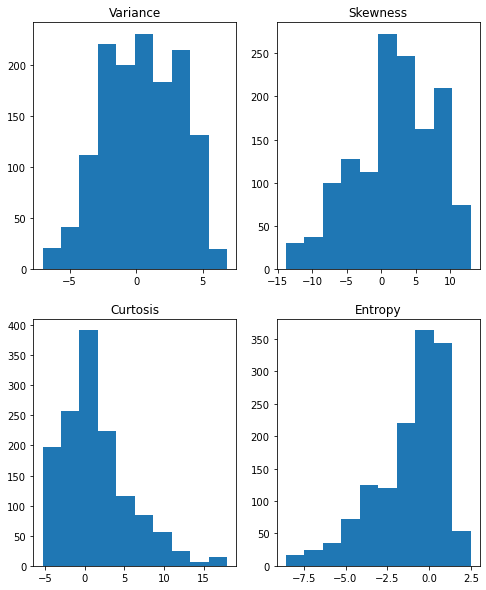

In [ ]:
plt.figure(figsize=(8,10))

plt.subplot(2,2,1)
plt.hist(banknotes["variance"])
plt.title("Variance")

plt.subplot(2,2,2)
plt.hist(banknotes["skewness"])
plt.title("Skewness")

plt.subplot(2,2,3)
plt.hist(banknotes["curtosis"])
plt.title("Curtosis")

plt.subplot(2,2,4)
plt.hist(banknotes["entropy"])
plt.title("Entropy")

In [ ]:
#if we get a kurtosis or a skewness between -3 and 3 its enough for us to do a t-test
print("Variance :", stats.describe(banknotes["variance"]))
print("Skewness :", stats.describe(banknotes["skewness"]))
print("Curtosis :", stats.describe(banknotes["curtosis"]))
print("Entropy :", stats.describe(banknotes["entropy"]))

Variance : DescribeResult(nobs=1372, minmax=(-7.0421, 6.8248), mean=0.4337352570699707, variance=8.081299121945177, skewness=-0.14922432617971165, kurtosis=-0.7532151685396653)
Skewness : DescribeResult(nobs=1372, minmax=(-13.7731, 12.9516), mean=1.9223531206393585, variance=34.44570967968295, skewness=-0.3936724723813983, kurtosis=-0.439989805593088)
Curtosis : DescribeResult(nobs=1372, minmax=(-5.2861, 17.9274), mean=1.3976271172667638, variance=18.57635937762427, skewness=1.0873780556996202, kurtosis=1.2614806308503308)
Entropy : DescribeResult(nobs=1372, minmax=(-8.5482, 2.4495), mean=-1.1916565200437317, variance=4.414256203357671, skewness=-1.0211250915668673, kurtosis=0.4913145791555622)


In [ ]:
#they're all normal enough, lets see if we can fix the skewness of curtosis and entropy a bit more
#curtosis and entropy are skewed, instead of dropping the outliers (so we wont be doing winsorization), lets transform them.
#i want to do log transformation, but my values have 0 and negatives. after reading online, i decide to add a constanst so all my values are greater than 1

entropy_min = np.abs(banknotes["entropy"].min()) + 1
curtosis_min = np.abs(banknotes["curtosis"].min()) + 1

entropy_above_0 = banknotes["entropy"] + entropy_min
curtosis_above_0 = banknotes["curtosis"] + curtosis_min



<function matplotlib.pyplot.show(close=None, block=None)>

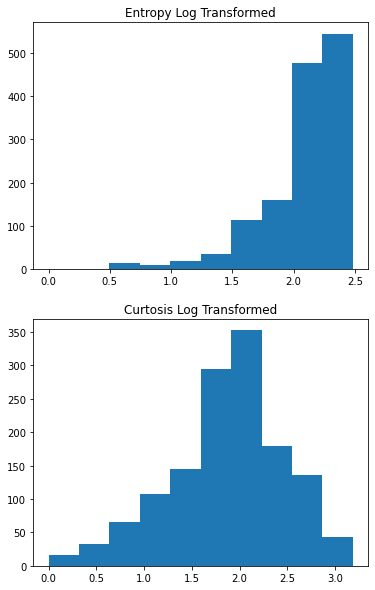

In [ ]:
#now lets log transform and see what the box plot for the new entropy and curtosis looks like
entropy_log = np.log(entropy_above_0)
curtosis_log = np.log(curtosis_above_0)

plt.figure(figsize=(6,10))

plt.subplot(2,1,1)
plt.hist(entropy_log)
plt.title("Entropy Log Transformed")

plt.subplot(2,1,2)
plt.hist(curtosis_log)
plt.title("Curtosis Log Transformed")

plt.show

In [ ]:
#log transformation helped normalized our curtosis data which had a right skew, but not so much for entropy
print("Curtosis :", stats.describe(curtosis_log))
print("Entropy :", stats.describe(entropy_log))

Curtosis : DescribeResult(nobs=1372, minmax=(0.0, 3.1869103288611504), mean=1.8763391558165352, variance=0.356608746979169, skewness=-0.4608146708184079, kurtosis=0.09073532141739316)
Entropy : DescribeResult(nobs=1372, minmax=(0.0, 2.4847149647509306), mean=2.0785788883560787, variance=0.10925097504118571, skewness=-2.0492563043789698, kurtosis=5.167206810120115)


Entropy squared: DescribeResult(nobs=1372, minmax=(2.9240999999999997e-06, 73.07172324), mean=5.831084077217087, variance=118.70837774019887, skewness=2.851643505882197, kurtosis=8.805242001096955)


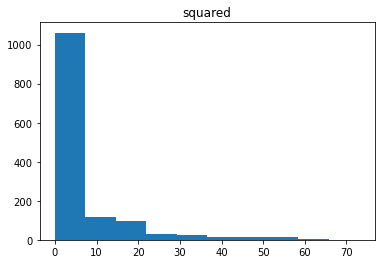

Entropy cubed: DescribeResult(nobs=1372, minmax=(-624.631704600168, 14.697123087375001), mean=-26.921516754166994, variance=5236.5889760845985, skewness=-4.027551742167725, kurtosis=18.219399845363128)


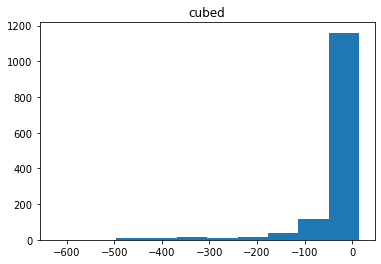

Entropy cuberoot: DescribeResult(nobs=1372, minmax=(-2.044677846523759, 1.3480080361826359), mean=-0.47775263060363093, variance=1.0490733536587422, skewness=0.39119897567274364, kurtosis=-1.4166531836199876)


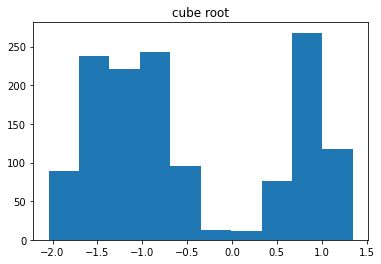

In [ ]:
#the skewness for entropy got worse after being log transformed
#two methods i found online for left skewed data is square, cube root, cubed, lets try all

entropy_squared = banknotes["entropy"]**2
print("Entropy squared:", stats.describe(entropy_squared))
plt.hist(entropy_squared)
plt.title("squared")
plt.show()

entropy_cubed = banknotes["entropy"]**3
print("Entropy cubed:", stats.describe(entropy_cubed))
plt.hist(entropy_cubed)
plt.title("cubed")
plt.show()

entropy_cube_root = np.cbrt(banknotes["entropy"])
print("Entropy cuberoot:", stats.describe(entropy_cube_root))
plt.hist(entropy_cube_root)
plt.title("cube root")

plt.show()

Entropy Transformed: DescribeResult(nobs=1372, minmax=(-3.8284955200001662, 3.8022181171464444), mean=-0.573577349787328, variance=1.9185067071711486, skewness=0.01819536210990069, kurtosis=-0.44016617918899303)


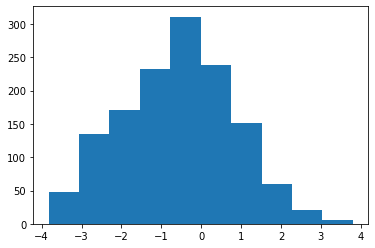

In [ ]:
# one last method to try is Yeo-Johnson Transformation
entropy_transformed, lmbda = stats.yeojohnson(banknotes["entropy"])
plt.hist(entropy_transformed)
print("Entropy Transformed:", stats.describe(entropy_transformed))

Variance Transformed: DescribeResult(nobs=1372, minmax=(-6.708715035295241, 7.161004019258549), mean=0.5094648979312033, variance=8.16230969062359, skewness=-0.06979877619550913, kurtosis=-0.8085470287849499)
Skewness Transformed: DescribeResult(nobs=1372, minmax=(-11.634129963972523, 15.318289081959847), mean=2.5722072605143578, variance=37.18372854641381, skewness=-0.0767696351152026, kurtosis=-0.7498148245329079)
Curtosis Transformed: DescribeResult(nobs=1372, minmax=(-7.451398685580177, 10.117147390874715), mean=0.4448459154852365, variance=12.451174889437938, skewness=0.0546424259701249, kurtosis=-0.2714416109144837)
Entropy Transformed: DescribeResult(nobs=1372, minmax=(-3.8284955200001662, 3.8022181171464444), mean=-0.573577349787328, variance=1.9185067071711486, skewness=0.01819536210990069, kurtosis=-0.44016617918899303)


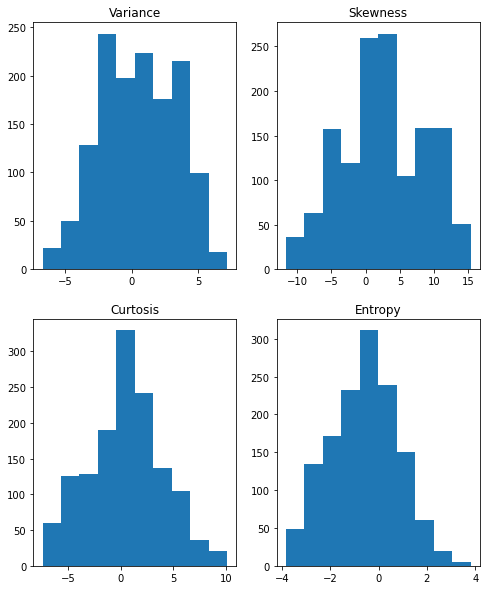

In [ ]:
#this shows terrific results, lets see how the other three features react
plt.figure(figsize=(8,10))

plt.subplot(2,2,1)
variance_transformed, lmbda = stats.yeojohnson(banknotes["variance"])
plt.hist(variance_transformed)
plt.title("Variance")
print("Variance Transformed:", stats.describe(variance_transformed))

plt.subplot(2,2,2)
skewness_transformed, lmbda = stats.yeojohnson(banknotes["skewness"])
plt.hist(skewness_transformed)
plt.title("Skewness")
print("Skewness Transformed:", stats.describe(skewness_transformed))

plt.subplot(2,2,3)
curtosis_transformed, lmbda = stats.yeojohnson(banknotes["curtosis"])
plt.hist(curtosis_transformed)
plt.title("Curtosis")
print("Curtosis Transformed:", stats.describe(curtosis_transformed))

plt.subplot(2,2,4)
entropy_transformed, lmbda = stats.yeojohnson(banknotes["entropy"])
plt.hist(entropy_transformed)
plt.title("Entropy")
print("Entropy Transformed:", stats.describe(entropy_transformed))


In [ ]:
#squaring made our skewness even greater, while cubing gave us a odd distribution around 0
#our original entropy has a skewness of -1, so we'll leave it alone.

banknotes["curtosis_log"] = curtosis_log
banknotes.head()

,variance,skewness,curtosis,entropy,class,curtosis_log
0,3.62160,8.6661,-2.8073,-0.44699,0,1.246687
1,4.54590,8.1674,-2.4586,-1.46210,0,1.342212
2,3.86600,-2.6383,1.9242,0.10645,0,2.105389
3,3.45660,9.5228,-4.0112,-3.59440,0,0.821936
4,0.32924,-4.4552,4.5718,-0.98880,0,2.384893


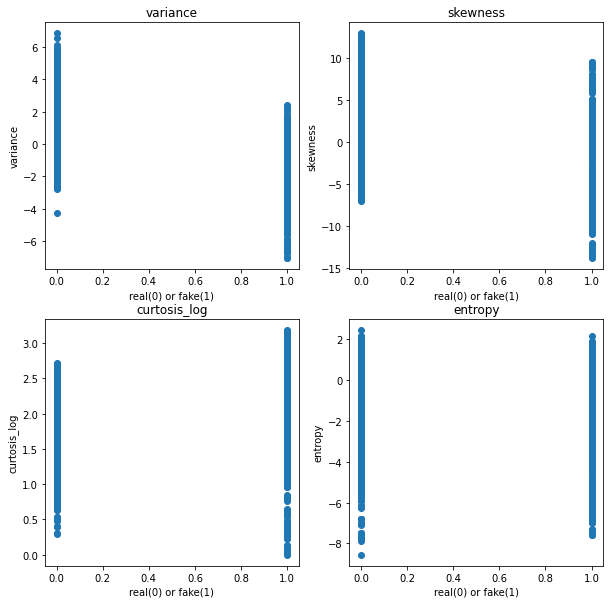

In [ ]:
#lets see if theres a visual correlation of some kind between these four variales and the class

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter(banknotes['class'], banknotes['variance'])
plt.xlabel('real(0) or fake(1)')
plt.ylabel('variance')
plt.title('variance')

plt.subplot(2, 2, 2)
plt.scatter(banknotes['class'], banknotes['skewness'])
plt.xlabel('real(0) or fake(1)')
plt.ylabel('skewness')
plt.title('skewness')

plt.subplot(2, 2, 3)
plt.scatter(banknotes['class'], banknotes['curtosis_log'])
plt.xlabel('real(0) or fake(1)')
plt.ylabel('curtosis_log')
plt.title('curtosis_log')

plt.subplot(2, 2, 4)
plt.scatter(banknotes['class'], banknotes['entropy'])
plt.xlabel('real(0) or fake(1)')
plt.ylabel('entropy')
plt.title('entropy')

plt.show()

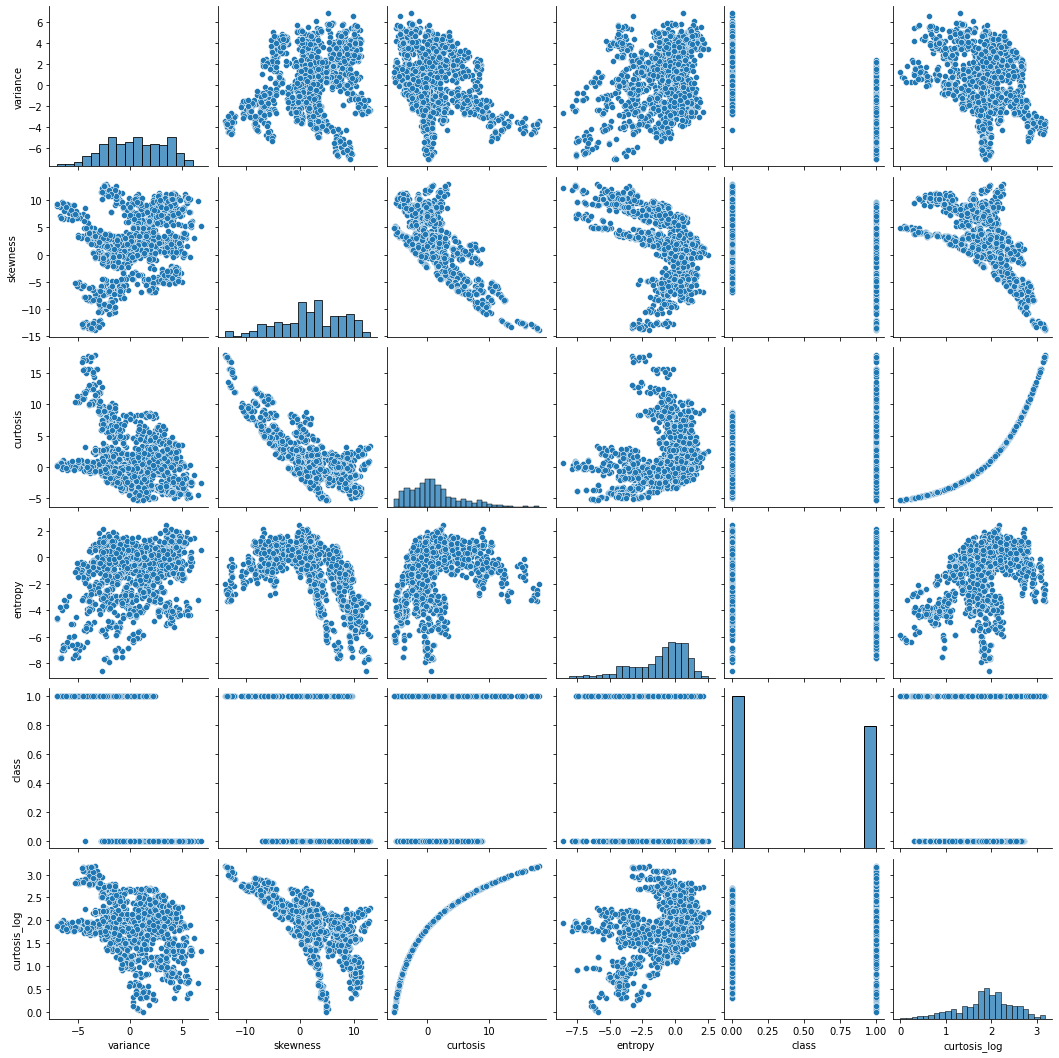

In [ ]:
sns.pairplot(banknotes)

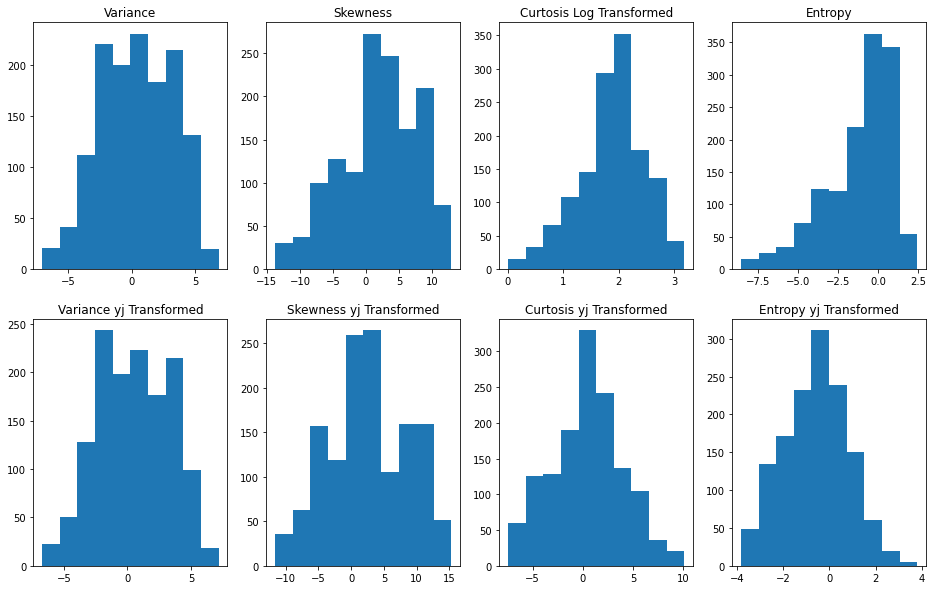

In [ ]:
#we can see some correlation between variance, skewness, and curtois to class. Curtosis and entropy seem related, entropy and skewness have an odd relation. Variance and skewness, variance and entropy seem almost random
#now we'll get into data exploration, lets begin by looking at histograms of our features
# univariate analysis of single variables

plt.figure(figsize=(16,10))

plt.subplot(2,4,1)
plt.hist(banknotes["variance"])
plt.title("Variance")

plt.subplot(2,4,2)
plt.hist(banknotes["skewness"])
plt.title("Skewness")

plt.subplot(2,4,3)
plt.hist(banknotes["curtosis_log"])
plt.title("Curtosis Log Transformed")

plt.subplot(2,4,4)
plt.hist(banknotes["entropy"])
plt.title("Entropy")

plt.subplot(2,4,5)
variance_transformed, lmbda = stats.yeojohnson(banknotes["variance"])
plt.hist(variance_transformed)
plt.title("Variance yj Transformed")

plt.subplot(2,4,6)
skewness_transformed, lmbda = stats.yeojohnson(banknotes["skewness"])
plt.hist(skewness_transformed)
plt.title("Skewness yj Transformed")

plt.subplot(2,4,7)
curtosis_transformed, lmbda = stats.yeojohnson(banknotes["curtosis"])
plt.hist(curtosis_transformed)
plt.title("Curtosis yj Transformed")

plt.subplot(2,4,8)
entropy_transformed, lmbda = stats.yeojohnson(banknotes["entropy"])
plt.hist(entropy_transformed)
plt.title("Entropy yj Transformed")

plt.show()

In [ ]:
# we have much better normalized data after Yeo Johnson Transformation, going forward, we'll use two different datasets
# the original, but only the curtosis will be log transformed
# the second, where all the features are Yeo Johnson transformed

banknotes = banknotes.drop(columns=['curtosis'])
banknotes_yj = pd.DataFrame(data=(entropy_transformed, curtosis_transformed, skewness_transformed, variance_transformed, banknotes["class"]), index = ['entropy transformed', 'curtosis transformed', 'skewness transformed', 'variance transformed', 'class']).transpose()

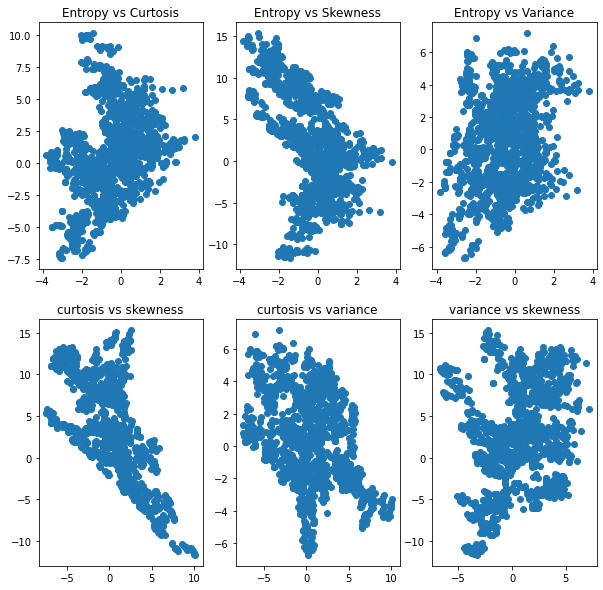

In [ ]:
#bivariate analysis of two variables, correlation is relatively the same for both versions
#we'll use banknotes_yj going forward

plt.figure(figsize=(10,10))

plt.subplot(2, 3, 1)
plt.scatter(banknotes_yj["entropy transformed"], banknotes_yj["curtosis transformed"])
plt.title("Entropy vs Curtosis")

plt.subplot(2, 3, 2)
plt.scatter(banknotes_yj["entropy transformed"], banknotes_yj["skewness transformed"])
plt.title("Entropy vs Skewness")

plt.subplot(2, 3, 3)
plt.scatter(banknotes_yj["entropy transformed"], banknotes_yj["variance transformed"])
plt.title("Entropy vs Variance")

plt.subplot(2, 3, 4)
plt.scatter(banknotes_yj["curtosis transformed"], banknotes_yj["skewness transformed"])
plt.title("curtosis vs skewness")

plt.subplot(2, 3, 5)
plt.scatter(banknotes_yj["curtosis transformed"], banknotes_yj["variance transformed"])
plt.title("curtosis vs variance")

plt.subplot(2, 3, 6)
plt.scatter(banknotes_yj["variance transformed"], banknotes_yj["skewness transformed"])
plt.title("variance vs skewness")

plt.show()

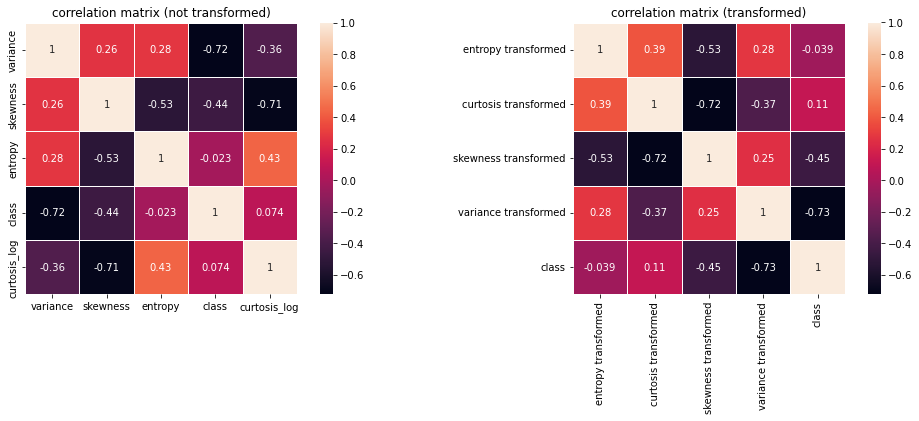

In [ ]:
#lets look at the correlation between features with a heat map

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# Draw the heat map using seaborn
sns.heatmap(banknotes.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (not transformed)")

plt.subplot(1,2,2)
# Draw the heat map using seaborn
sns.heatmap(banknotes_yj.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (transformed)")

plt.show()


In [ ]:
np.abs(banknotes.corr())

,variance,skewness,entropy,class,curtosis_log
variance,1.000000,0.264026,0.276817,0.724843,0.357887
skewness,0.264026,1.000000,0.526321,0.444688,0.707005
entropy,0.276817,0.526321,1.000000,0.023424,0.434209
class,0.724843,0.444688,0.023424,1.000000,0.073735
curtosis_log,0.357887,0.707005,0.434209,0.073735,1.000000


In [ ]:
np.abs(banknotes.corr()['class']).sort_values(ascending=False)

class           1.000000
variance        0.724843
skewness        0.444688
curtosis_log    0.073735
entropy         0.023424
Name: class, dtype: float64

In [ ]:
np.abs(banknotes_yj.corr())

,entropy transformed,curtosis transformed,skewness transformed,variance transformed,class
entropy transformed,1.000000,0.386497,0.528400,0.277916,0.038642
curtosis transformed,0.386497,1.000000,0.724353,0.371762,0.105222
skewness transformed,0.528400,0.724353,1.000000,0.248615,0.451239
variance transformed,0.277916,0.371762,0.248615,1.000000,0.725189
class,0.038642,0.105222,0.451239,0.725189,1.000000


In [ ]:
np.abs(banknotes_yj.corr()['class']).sort_values(ascending=False)

class                   1.000000
variance transformed    0.725189
skewness transformed    0.451239
curtosis transformed    0.105222
entropy transformed     0.038642
Name: class, dtype: float64

In [ ]:
#moving onto feature engineering
#lets see if our old values do well in the jarque_bera and normality tests
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb = jarque_bera(banknotes["variance"])
norm = normaltest(banknotes["variance"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

jb = jarque_bera(banknotes["skewness"])
norm = normaltest(banknotes["skewness"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

jb = jarque_bera(banknotes["entropy"])
norm = normaltest(banknotes["entropy"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

jb = jarque_bera(banknotes["curtosis_log"])
norm = normaltest(banknotes["curtosis_log"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

Jarque-Bera test statistics is 37.52446800953222 and p value is 7.106656152444657e-09
Normality test statistics is 95.53089490739131 and p value is 1.8018960996631497e-21
Jarque-Bera test statistics is 46.50526003946595 and p value is 7.97096832982902e-11
Normality test statistics is 51.26952922828647 and p value is 7.361446890369984e-12
Jarque-Bera test statistics is 252.22938473113302 and p value is 0.0
Normality test statistics is 179.75209469429677 and p value is 9.275313167499287e-40
Jarque-Bera test statistics is 49.02805081301491 and p value is 2.2578494629499346e-11
Normality test statistics is 45.248364397986904 and p value is 1.4943162299520937e-10


In [ ]:
# pretty good values, not for entropy though
# now lets see after the transformation

jb = jarque_bera(banknotes_yj["variance transformed"])
norm = normaltest(banknotes_yj["variance transformed"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

jb = jarque_bera(banknotes_yj["skewness transformed"])
norm = normaltest(banknotes_yj["skewness transformed"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

jb = jarque_bera(banknotes_yj["entropy transformed"])
norm = normaltest(banknotes_yj["entropy transformed"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

jb = jarque_bera(banknotes_yj["curtosis transformed"])
norm = normaltest(banknotes_yj["curtosis transformed"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb[0], jb[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm[0], norm[1]))

Jarque-Bera test statistics is 38.48664510265884 and p value is 4.392696539845531e-09
Normality test statistics is 118.45370588804859 and p value is 1.897162737080547e-26
Jarque-Bera test statistics is 33.488037742854154 and p value is 5.347674925104684e-08
Normality test statistics is 90.35898752962252 and p value is 2.3921872028082423e-20
Jarque-Bera test statistics is 11.151533114683312 and p value is 0.003788570312375561
Normality test statistics is 17.983399260880272 and p value is 0.00012443841408386655
Jarque-Bera test statistics is 4.894823060135357 and p value is 0.08651724419410645
Normality test statistics is 5.965108659533708 and p value is 0.05066325777789524


In [ ]:
# seems like the best move would be to keep all the original values, yj transformed entropy, and log transformed curtosis
banknotes_transformed = pd.DataFrame(data=(entropy_transformed, banknotes["curtosis_log"], banknotes["skewness"], banknotes["variance"], banknotes["class"]), index = ['entropy transformed', 'curtosis log', 'skewness', 'variance', 'class']).transpose()
np.abs(banknotes_transformed.corr())


,entropy transformed,curtosis log,skewness,variance,class
entropy transformed,1.000000,0.420867,0.487059,0.279688,0.038642
curtosis log,0.420867,1.000000,0.707005,0.357887,0.073735
skewness,0.487059,0.707005,1.000000,0.264026,0.444688
variance,0.279688,0.357887,0.264026,1.000000,0.724843
class,0.038642,0.073735,0.444688,0.724843,1.000000


In [ ]:
# we'll make two different dataframes, one that is normalized, and one that is standardized
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

banknotes_normalized = banknotes_transformed
banknotes_normalized["entropy transformed"] = normalize(np.array(banknotes_transformed["entropy transformed"]).reshape(1,-1)).reshape(-1,1)
banknotes_normalized["curtosis log"] = normalize(np.array(banknotes_transformed["curtosis log"]).reshape(1,-1)).reshape(-1,1)
banknotes_normalized["skewness"] = normalize(np.array(banknotes_transformed["skewness"]).reshape(1,-1)).reshape(-1,1)
banknotes_normalized["variance"] = normalize(np.array(banknotes_transformed["variance"]).reshape(1,-1)).reshape(-1,1)

banknotes_scaled = banknotes_transformed
banknotes_scaled["entropy transformed"] = scale(banknotes_transformed["entropy transformed"])
banknotes_scaled["curtosis log"] = scale(banknotes_transformed["curtosis log"])
banknotes_scaled["skewness"] = scale(banknotes_transformed["skewness"])
banknotes_scaled["variance"] = scale(banknotes_transformed["variance"])

In [ ]:
banknotes_normalized.head()

,entropy transformed,curtosis log,skewness,variance,class
0,0.124838,-1.054782,1.149455,1.121806,0.0
1,-0.381900,-0.894761,1.064453,1.447066,0.0
2,0.493421,0.383701,-0.777352,1.207810,0.0
3,-1.146542,-1.766318,1.295478,1.063742,0.0
4,-0.164250,0.851921,-1.087038,-0.036772,0.0


In [ ]:
banknotes_scaled.head()

,entropy transformed,curtosis log,skewness,variance,class
0,0.124838,-1.054782,1.149455,1.121806,0.0
1,-0.381900,-0.894761,1.064453,1.447066,0.0
2,0.493421,0.383701,-0.777352,1.207810,0.0
3,-1.146542,-1.766318,1.295478,1.063742,0.0
4,-0.164250,0.851921,-1.087038,-0.036772,0.0


In [ ]:
banknotes_normalized = banknotes_transformed
banknotes_normalized["entropy transformed"] = normalize(np.array(banknotes_transformed["entropy transformed"]).reshape(1,-1)).reshape(-1,1)
banknotes_normalized["curtosis log"] = normalize(np.array(banknotes_transformed["curtosis log"]).reshape(1,-1)).reshape(-1,1)
banknotes_normalized["skewness"] = normalize(np.array(banknotes_transformed["skewness"]).reshape(1,-1)).reshape(-1,1)
banknotes_normalized["variance"] = normalize(np.array(banknotes_transformed["variance"]).reshape(1,-1)).reshape(-1,1)


In [ ]:
banknotes_normalized.head()

,entropy transformed,curtosis log,skewness,variance,class
0,0.003370,-0.028476,0.031032,0.030286,0.0
1,-0.010310,-0.024156,0.028738,0.039067,0.0
2,0.013321,0.010359,-0.020987,0.032608,0.0
3,-0.030954,-0.047686,0.034975,0.028718,0.0
4,-0.004434,0.023000,-0.029347,-0.000993,0.0


In [ ]:
col_to_keep = ['entropy transformed', 'curtosis log', 'skewness', 'variance']
X = banknotes_normalized[col_to_keep]
Y = banknotes_normalized['class']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.16, random_state = 42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

y_preds_test = lr.predict(X_test)
accuracy=cross_val_score(lr, X_train, Y_train, cv=5)

print("R-squared of the model in the training set is: {}".format(lr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8892998471718309
-----Test set statistics-----
R-squared of the model in the test set is: 0.886474809129123
Mean absolute error of the prediction is: 0.12306382340583402
Mean squared error of the prediction is: 0.028097484740542075
Root mean squared error of the prediction is: 0.16762304358453248
Mean absolute percentage error of the prediction is: inf
Accuracy: 0.887 (+/- 0.039)


In [ ]:
for k in range(25):
    k = k+1
    knn = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    knn.fit(X_train, Y_train)
    
    y_preds_test = knn.predict(X_test)
    accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)
    
    print("K is {} and RMSE of the prediction is: {}".format(k, round(rmse(Y_test, y_preds_test),6)))
    print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

K is 1 and RMSE of the prediction is: 0.0
Accuracy: 0.993 (+/- 0.017)
K is 2 and RMSE of the prediction is: 0.0
Accuracy: 0.992 (+/- 0.019)
K is 3 and RMSE of the prediction is: 0.0
Accuracy: 0.992 (+/- 0.021)
K is 4 and RMSE of the prediction is: 0.0
Accuracy: 0.991 (+/- 0.022)
K is 5 and RMSE of the prediction is: 0.0
Accuracy: 0.991 (+/- 0.023)
K is 6 and RMSE of the prediction is: 0.0
Accuracy: 0.991 (+/- 0.024)
K is 7 and RMSE of the prediction is: 0.0
Accuracy: 0.991 (+/- 0.022)
K is 8 and RMSE of the prediction is: 0.00647
Accuracy: 0.991 (+/- 0.021)
K is 9 and RMSE of the prediction is: 0.011573
Accuracy: 0.992 (+/- 0.020)
K is 10 and RMSE of the prediction is: 0.015999
Accuracy: 0.992 (+/- 0.019)
K is 11 and RMSE of the prediction is: 0.019477
Accuracy: 0.992 (+/- 0.017)
K is 12 and RMSE of the prediction is: 0.022603
Accuracy: 0.992 (+/- 0.017)
K is 13 and RMSE of the prediction is: 0.021296
Accuracy: 0.992 (+/- 0.017)
K is 14 and RMSE of the prediction is: 0.02379
Accuracy: 

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 1, weights = 'distance')
knn.fit(X_train, Y_train)

y_preds_test = knn.predict(X_test)
accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: 1.0
Mean absolute error of the prediction is: 0.0
Mean squared error of the prediction is: 0.0
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.0
Accuracy: 0.993 (+/- 0.017)


In [ ]:
params = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


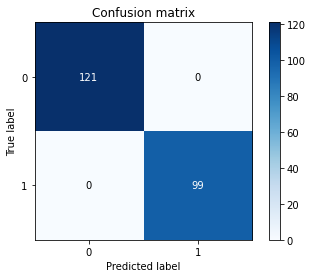

In [ ]:
cm = confusion_matrix(Y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


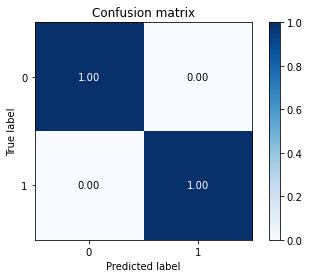

In [ ]:
cm = confusion_matrix(Y_test, predict_test)
plot_confusion_matrix(cm,[0,1],True)

In [ ]:
clf.score(X_test, Y_test)

1.0

In [ ]:
y_pred = clf.predict(X_test)
precision_score(Y_test,y_pred)

1.0

In [ ]:
recall_score(Y_test,y_pred)

1.0

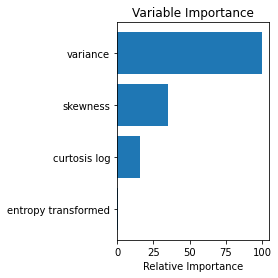

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Surprisingly, Deep Tree Classifiers and Nearest Neighbors perfect predictions. I originally thought that LogisticRegression would give the most accurate predictions.

Using our model, we can now predict from 4 features of banknote, whether or not a banknote is authentic.

In [ ]:
col_to_keep = ['curtosis log', 'skewness', 'variance']
X = banknotes_normalized[col_to_keep]
Y = banknotes_normalized['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)

y_preds_test = lr.predict(X_test)
accuracy=cross_val_score(lr, X_train, Y_train, cv=5)

print("R-squared of the model in the training set is: {}".format(lr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8590499260503099
-----Test set statistics-----
R-squared of the model in the test set is: 0.8625325555347948
Mean absolute error of the prediction is: 0.1421956221228374
Mean squared error of the prediction is: 0.033904882727004246
Root mean squared error of the prediction is: 0.18413278558421975
Mean absolute percentage error of the prediction is: inf
Accuracy: 0.858 (+/- 0.026)


In [ ]:
for k in range(25):
    k = k+1
    knn = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    knn.fit(X_train, Y_train)
    
    y_preds_test = knn.predict(X_test)
    accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)
    
    print("K is {} and RMSE of the prediction is: {}".format(k, round(rmse(Y_test, y_preds_test),6)))
    print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

K is 1 and RMSE of the prediction is: 0.0
Accuracy: 0.993 (+/- 0.016)
K is 2 and RMSE of the prediction is: 0.0
Accuracy: 0.995 (+/- 0.012)
K is 3 and RMSE of the prediction is: 0.0
Accuracy: 0.995 (+/- 0.013)
K is 4 and RMSE of the prediction is: 0.0
Accuracy: 0.994 (+/- 0.012)
K is 5 and RMSE of the prediction is: 0.010172
Accuracy: 0.993 (+/- 0.012)
K is 6 and RMSE of the prediction is: 0.018173
Accuracy: 0.993 (+/- 0.010)
K is 7 and RMSE of the prediction is: 0.02463
Accuracy: 0.993 (+/- 0.010)
K is 8 and RMSE of the prediction is: 0.029951
Accuracy: 0.992 (+/- 0.011)
K is 9 and RMSE of the prediction is: 0.028116
Accuracy: 0.991 (+/- 0.011)
K is 10 and RMSE of the prediction is: 0.026593
Accuracy: 0.991 (+/- 0.009)
K is 11 and RMSE of the prediction is: 0.025317
Accuracy: 0.990 (+/- 0.010)
K is 12 and RMSE of the prediction is: 0.024193
Accuracy: 0.989 (+/- 0.010)
K is 13 and RMSE of the prediction is: 0.023191
Accuracy: 0.988 (+/- 0.011)
K is 14 and RMSE of the prediction is: 0.0

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 1, weights = 'distance')
knn.fit(X_train, Y_train)

y_preds_test = knn.predict(X_test)
accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: 1.0
Mean absolute error of the prediction is: 0.0
Mean squared error of the prediction is: 0.0
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.0
Accuracy: 0.993 (+/- 0.016)


In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 2, weights = 'distance')
knn.fit(X_train, Y_train)

y_preds_test = knn.predict(X_test)
accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: 1.0
Mean absolute error of the prediction is: 0.0
Mean squared error of the prediction is: 0.0
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.0
Accuracy: 0.995 (+/- 0.012)


In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 3, weights = 'distance')
knn.fit(X_train, Y_train)

y_preds_test = knn.predict(X_test)
accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: 1.0
Mean absolute error of the prediction is: 0.0
Mean squared error of the prediction is: 0.0
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.0
Accuracy: 0.995 (+/- 0.013)


In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 4, weights = 'distance')
knn.fit(X_train, Y_train)

y_preds_test = knn.predict(X_test)
accuracy = cross_val_score(knn, X_train, Y_train, cv = 5)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: 1.0
Mean absolute error of the prediction is: 0.0
Mean squared error of the prediction is: 0.0
Root mean squared error of the prediction is: 0.0
Mean absolute percentage error of the prediction is: 0.0
Accuracy: 0.994 (+/- 0.012)


In [ ]:
params = {'n_estimators': 500,
          'max_depth': 3,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
clf.score(X_test, Y_test)

1.0

If we remove the 'entropy transformed' feature, we can raise our Nearest Neighbor model to 100% accuracy. The LinearRegression model goes down a bit though.

Conclusion: Not only have we shown a correlation between the 4 features and whether the banknotes are real or fake, but we have also devised a model that can predict, with an accuracy of 100% whether the banknote in question is real or fake depending on the values of 4 of its features. Our hypothesis was correct!